# Cat and Dog Dataset - VGG16 으로 학습
- Cats and Dogs dataset to train DL model
- 캐글의 [Cat and Dog](https://www.kaggle.com/tongpython/cat-and-dog)

In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 데이터 다운로드

In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghyungheejang","key":"173a511b907e19322c2940170271f691"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# permmision warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip -d catanddog/
data_dir = './catanddog/'

### 데이터 적재

In [7]:
train_cats =glob.glob(data_dir + '/training_set/training_set/cats/*.jpg')
train_dogs =glob.glob(data_dir + '/training_set/training_set/dogs/*.jpg')

test_cats =glob.glob(data_dir + '/test_set/test_set/cats/*.jpg')
test_dogs =glob.glob(data_dir + '/test_set/test_set/dogs/*.jpg')

In [ ]:
train_dogs

In [10]:
print(len(train_cats), len(train_dogs))
print(len(test_cats), len(test_dogs))

4000 4005
1011 1012


### 데이터 시각화

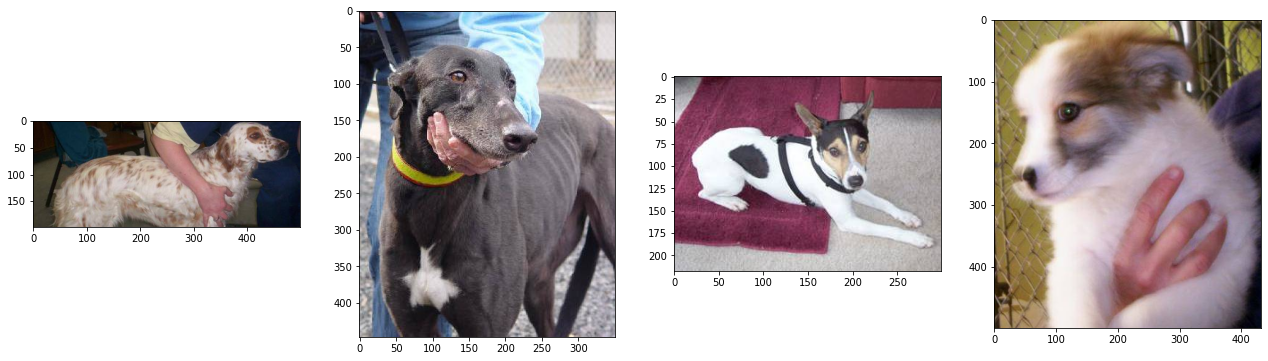

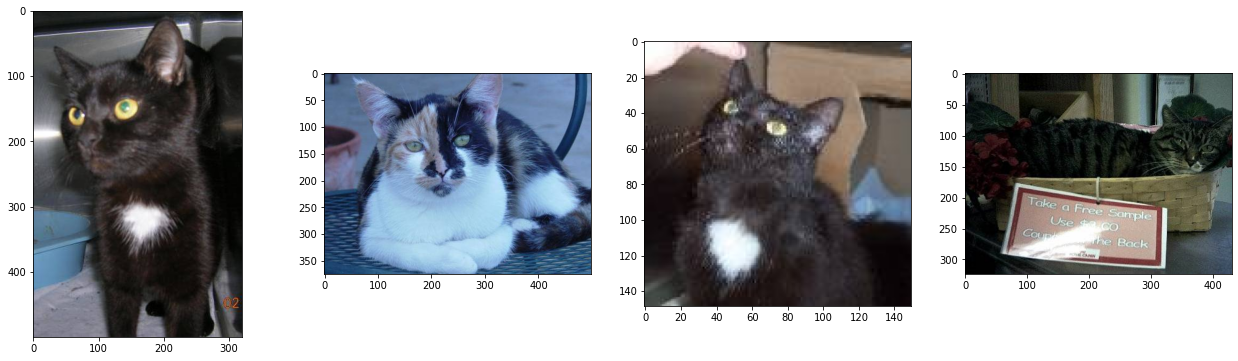

In [11]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

dog_filepaths = train_dogs[:4]

for i in range(4):
    dog_image = cv2.cvtColor(cv2.imread(dog_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(dog_image)
    
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

cat_filepaths = train_cats[:4]

for i in range(4):
    cat_image = cv2.cvtColor(cv2.imread(cat_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(cat_image)
    

### 데이터 전처리 (using "from dataframe")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# train_df
train_path = train_cats + train_dogs # 4000 4005 (Cat/Dog)
train_label = ["CAT" for _ in range(len(train_cats))] + ["DOG" for _ in range(len(train_dogs))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})


# test_df
test_paths = test_cats + test_dogs # 1011 1012 (Cat/Dog)
test_label = ["CAT" for _ in range(len(test_cats))] + ["DOG" for _ in range(len(test_dogs))]
test_df = pd.DataFrame({"path":test_paths, "label":test_label})

# valid_df
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

DOG    3204
CAT    3200
Name: label, dtype: int64
DOG    801
CAT    800
Name: label, dtype: int64


In [ ]:
pd.set_option("display.max_colwidth", 200)
train_df.head()

,path,label
3578,./catanddog/training_set/training_set/cats/cat.1675.jpg,CAT
2346,./catanddog/training_set/training_set/cats/cat.363.jpg,CAT
5109,./catanddog/training_set/training_set/dogs/dog.1553.jpg,DOG
3259,./catanddog/training_set/training_set/cats/cat.2736.jpg,CAT
1852,./catanddog/training_set/training_set/cats/cat.2522.jpg,CAT


In [ ]:
BATCH_SIZE = 64
# train_generator
train_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 20, 
                                    rescale = 1/255.0
                                    ) # 다양한 Augmentation 시도해보기!!!
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=True)

# valid_generator
valid_generator = ImageDataGenerator(rescale = 1/255.0)

valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)


# test_generator
test_generator = ImageDataGenerator(rescale = 1/255.0)

test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)

Found 6404 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.
Found 2023 validated image filenames belonging to 2 classes.


In [ ]:
train_batch, label_batch = next(train_generator_iterator)
train_batch.shape, label_batch.shape

((64, 224, 224, 3), (64,))

### 모델 생성 및 학습

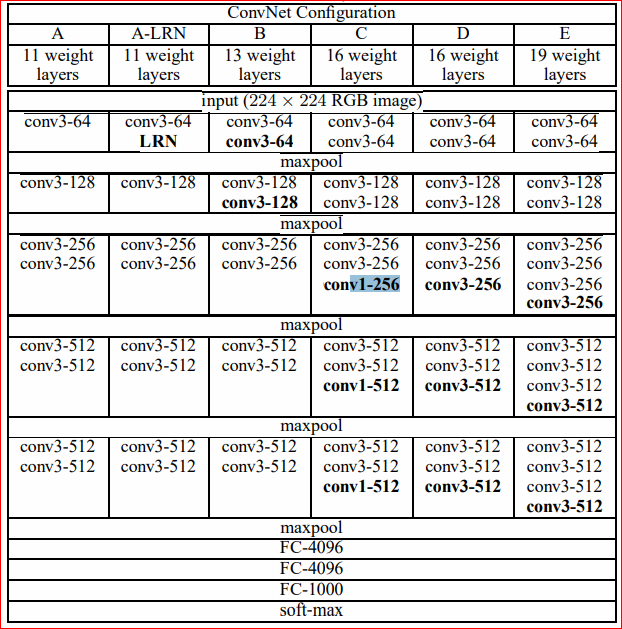

In [ ]:
IMAGE_SIZE = 224

def build_vgg16():
  tf.keras.backend.clear_session()
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
  x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block1_conv1")(input_tensor)
  x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block1_conv2")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool")(x) 

  x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block2_conv1")(x)
  x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block2_conv2")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool")(x) 
    
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv1")(x)
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv2")(x)  
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool")(x) 

  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv1")(x)
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv2")(x)  
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool")(x) 
    
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv1")(x)
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv2")(x)  
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool")(x)   # 7*7*512
    

  x = GlobalAveragePooling2D()(x) # 512
  x = Dense(50, activation="relu")(x)
  output = Dense(units=1, activation='sigmoid')(x)


  model = Model(inputs=input_tensor, outputs=output)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
  return model

model = build_vgg16()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [ ]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [ ]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

### 모델 평가

In [ ]:
model.evaluate(test_generator_iterator)

In [ ]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir=./my_logs --port=6006

## VGG16 Pre-trained Model 활용
- weight를 imagenet에서 훈련된 가중치로 초기화

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(input_tensor = input_tensor, include_top=False, weights="imagenet")


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(50, activation="relu")(x)
output = Dense(units=1, activation='sigmoid')(x)


model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
model.summary()

In [ ]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [ ]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

In [ ]:
model.evaluate(test_generator_iterator)

In [ ]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

## 전이학습 (Transfer Learning)

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(input_tensor = input_tensor, include_top=False, weights="imagenet")


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(50, activation="relu")(x)
output = Dense(units=1, activation='sigmoid')(x)


model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
model.summary()

In [ ]:
model.layers

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)

In [ ]:
type(model.layers)

In [ ]:
for layer in model.layers[:-3]:
    layer.trainable = False
    print(layer.name, layer.trainable)
for layer in model.layers[-3:]:
    print(layer.name, layer.trainable)

In [ ]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [ ]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])